# Prática 1

## Inferência Bayesiana

***Estatística para Ciência de Dados***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**






### Exercício:

Na aplicação de dados bancários que vimos na Aula 1 (clientes do banco), considere diferentes tamanhos de amostra e diferentes prioris e veja como interferem na posteriori.  Uma possibilidade seria considerar uma distribuição a priori beta para a proporção p, com diferentes parâmetros. Outra possibilidade seria considerar uma distribuição a priori uniforme para p.

### Exemplo de priori conjugada beta-Bernoulli

Ver https://towardsdatascience.com/conjugate-prior-explained-75957dc80bfb



No exemplo do banco, se considerarmos que


- $X=\left\{ \begin{array}{lll} 1, &\mbox{se o cliente é classificado como inadimplente,} \\ 0, &\mbox{caso contrário.} \end{array}\right.$


- $X \sim Bernoulli(p)$


- Verossimilhança:

Para $n$ suficientemente grande, pelo TLC sabemos que a distribuição amostral de $\bar{X}$ se aproxima da normal $$\bar{X} \sim N\left(p, \displaystyle{\frac{p(1-p)}{n}}\right)$$


Além disso, $Y = \sum_{i=1}^{n} X_i \sim binomial(n,p)$. 





In [ ]:
import pandas as pd

pkgdir = '/home/cibele/CibelePython/ECD/Data'


# Dados banco - Leitura dos dados
dados = pd.read_csv(f'{pkgdir}/dados_banco.csv', index_col=0, decimal=',')

dados.head()

**Considere diferentes tamanhos de amostra. Como interferem na posteriori?** 

In [3]:
# Vamos trabalhar com uma amostra

import random

a = 2
b = 8

amostra = dados.sample(n=500, replace=False, random_state=10)

n = len(amostra)
k = amostra['Inadimplente'].sum()
posteriori = beta(a + k, n - k + b) 

k/n

0.242

**Considere diferentes tipos de priori, por exemplo beta ou uniforme. Como interferem na posteriori?**

## Priori 1 - beta

- Priori: $p \sim beta(2, 8)$


- Posteriori: $p|k \sim beta(k+a, n-k+b)$

onde $k$ é o número de sucessos observados na amostra.


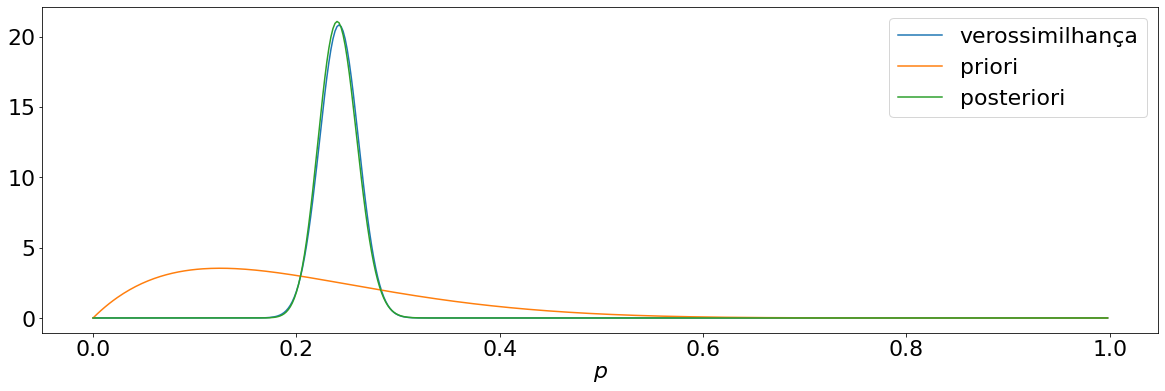

In [4]:
from scipy.stats import norm

# Eixo x entre 0 e 1 de .002 em .002.
x_axis = np.arange(0, 1, 0.002)

# Plota as densidades da beta para cada conjunto de parâmetros
plt.figure(figsize=(20,6))
    
prior = beta(a, b)

p_chapeu = amostra['Inadimplente'].mean()
dp = np.sqrt(p_chapeu*(1-p_chapeu)/n)

media = p_chapeu
dp = np.sqrt(media*(1-media)/n)

plt.s = 0
plt.rcParams.update({'font.size': 22})

plt.plot(x_axis, norm.pdf(x_axis, media, dp), label='verossimilhança')
plt.plot(x_axis, prior.pdf(x_axis), label='priori')
plt.plot(x_axis, posteriori.pdf(x_axis), label='posteriori')    
plt.xlabel(r'$p$')
plt.legend()


In [5]:
# Estimador bayesiano EAP (Esperança a posteriori)
print('Média: %.2f' % posteriori.mean())


# E para calcular um intervalo de credibilidade, decidimos uma probabilidade 
# Por exemplo 95% para a credibilidade
# Uma maneira seria definir que 2,5% de cada cauda como os limites do intervalo (chamado intervalo simétrico)
# Este método é válido quando a posteriori se aproxima de uma distribuição simétrica, pois nesse caso tende a gerar o intervalo com menor amplitude
# A seguir, apresentamos outra solução com um intervalo de credibilidade de menor amplitude.

LI = posteriori.ppf(.025)
LS = posteriori.ppf(.975)
print("Intervalo com 95% de credibilidade: {:.3f}, {:.3f})".format(LI,LS))


Média: 0.24
Intervalo com 95% de credibilidade: 0.205, 0.279)


## Exemplos




In [6]:
#!pip install pymc3==3.11.1


In [7]:
#!pip install arviz==0.11.2

In [36]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt


In [37]:
!pip show pymc3

Name: pymc3
Version: 3.11.1
Summary: Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with Theano
Home-page: http://github.com/pymc-devs/pymc3
Author: None
Author-email: None
License: Apache License, Version 2.0
Location: /home/cibele/anaconda3/lib/python3.7/site-packages
Requires: dill, patsy, fastprogress, scipy, theano-pymc, typing-extensions, numpy, arviz, pandas
Required-by: 


In [38]:
!pip show arviz

Name: arviz
Version: 0.11.2
Summary: Exploratory analysis of Bayesian models
Home-page: http://github.com/arviz-devs/arviz
Author: ArviZ Developers
Author-email: None
License: Apache-2.0
Location: /home/cibele/anaconda3/lib/python3.7/site-packages
Requires: numpy, pandas, matplotlib, setuptools, netcdf4, scipy, xarray, packaging, typing-extensions
Required-by: pymc3


## Modelo beta-Bernoulli: clientes do banco 

Com amostra de 500 observações, considere, por exemplo, priori beta (10,5). Compare com os resultados obtidos em aula.

In [55]:
with pm.Model() as model:
    p = pm.Beta("p", 10, 5)
    obs = pm.distributions.discrete.Bernoulli("obs", p, observed=amostra['Inadimplente'])

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 4 seconds.


In [56]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.254,0.019,0.219,0.29,0.0,0.0,1978.0,2963.0,1.0


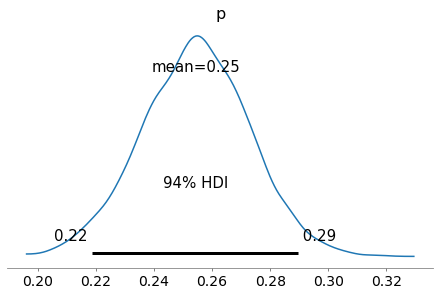

In [57]:
az.plot_posterior(idata);


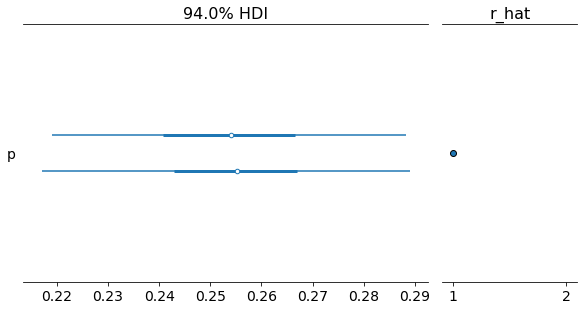

In [58]:
az.plot_forest(idata, r_hat=True);

### Análise de resultados

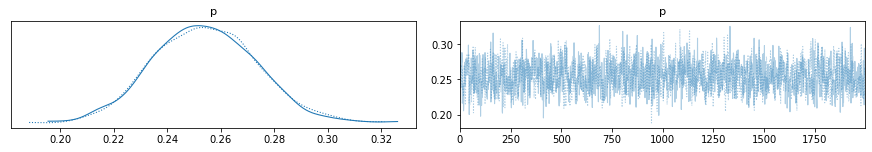

In [51]:
az.plot_trace(idata);


In [53]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.254,0.019,0.216,0.288,0.0,0.0,1578.0,2622.0,1.0


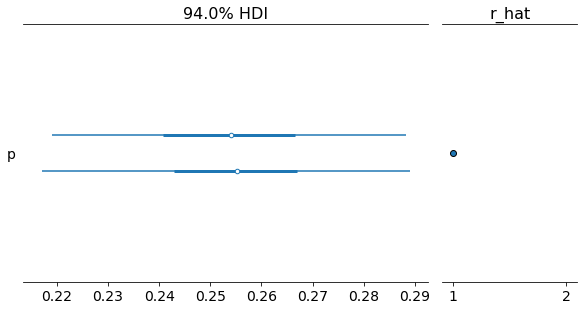

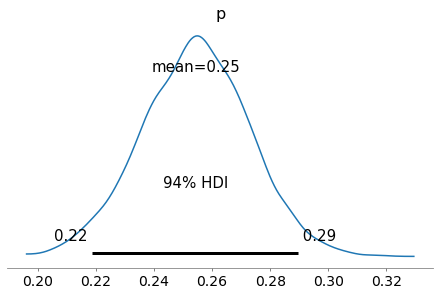

In [59]:
az.plot_forest(idata, r_hat=True);

az.plot_posterior(idata);


## Priori uniforme

Considere agora, por exemplo, priori uniforme para a proporção p. Como interfere na posteriori?

**Refaça as análises com diferentes tamanhos de amostra, por exemplo 100 ou 10000.**

In [60]:
with pm.Model() as model:
    p = pm.Uniform("p")
    obs = pm.distributions.discrete.Bernoulli("obs", p, observed=amostra['Inadimplente'])

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 3 seconds.


In [61]:
az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.243,0.019,0.207,0.277,0.0,0.0,1677.0,2530.0,1.0


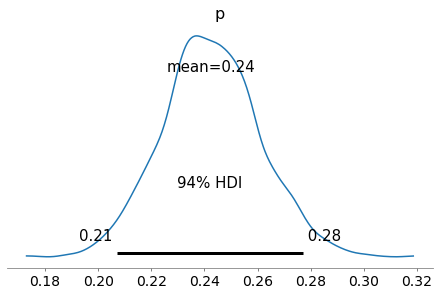

In [62]:
az.plot_posterior(idata);


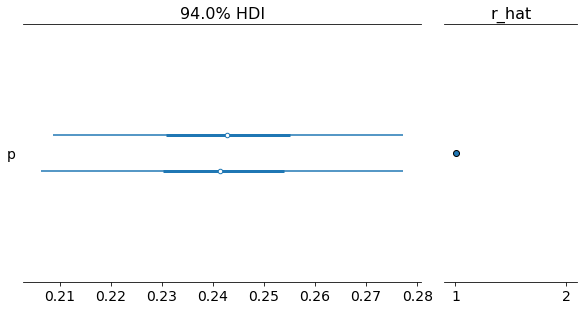

In [63]:
az.plot_forest(idata, r_hat=True);


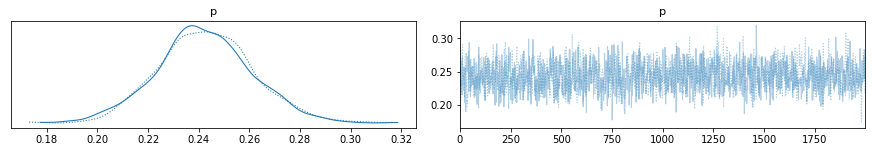

In [64]:

### Análise de resultados

az.plot_trace(idata);



In [65]:

az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.243,0.019,0.207,0.277,0.0,0.0,1677.0,2530.0,1.0


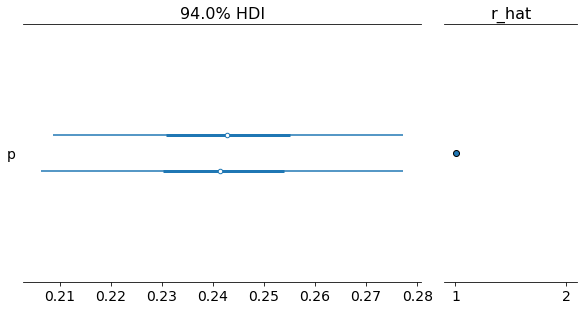

In [66]:

az.plot_forest(idata, r_hat=True);


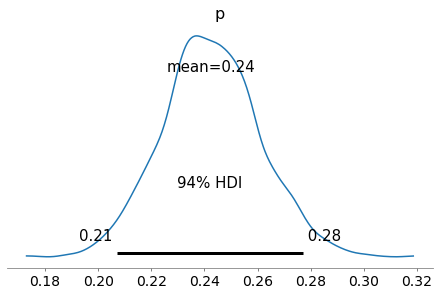

In [67]:

az.plot_posterior(idata);
